# Experience : Risk a l'aversion

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
# Ajouter le dossier src au chemin d'importation
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [3]:
import matplotlib.pyplot as plt
import torch 
import numpy as np

In [4]:
from environments.risk_aversion_env import RiskAversionEnvironment
from models.qlearning import QLearning

In [27]:
import tqdm

### Configuration de l'environnement

In [5]:
# Configuration de l'environnement
initial_energy = torch.tensor([10])  # Énergie initiale de l'agent
weights = torch.tensor([1.0])  # Poids pour l'énergie interne
exponents = [2, 2]  # Non-linéarité du drive
effects = {}  # Placeholder pour les effets
max_timestep = 100 # Nombre maximal d'itérations dans l'environnement pour un episode

# Paramètres pour les rewards risqués et non risqués
risky_reward = 8  # Énergie ajoutée pour l'état risqué
non_risky_reward = 2  # Énergie ajoutée pour l'état non risqué
risky_probability = 0.25  # Probabilité d'obtenir l'énergie dans l'état risqué

setpoint_energy = torch.tensor([0])  # Setpoint pour l'énergie optimale

# Instanciation de l'environnement
env = RiskAversionEnvironment(
    H=initial_energy,
    setpoints=setpoint_energy,
    weights=weights,
    exponents=exponents,
    effects=effects,
    risky_reward=risky_reward,
    non_risky_reward=non_risky_reward,
    risky_prob=risky_probability,
    max_timestep=max_timestep
)

### Configuration de l'agent

In [6]:
# Création de la Q-table pour l'expérience aversion au risque

# Instancier l'agent Q-learning
state_size = 2
action_size = 2  
alpha = 0.25 # Taux d'apprentissage
gamma = 0.8 # Discount factor
beta = 10 # Facteur d'exploration
nb_agents = 300 # Nombre d'agents
#agents = [QLearning(state_size=state_size, action_size=action_size, alpha=alpha, gamma=gamma, beta=beta) for _ in range(nb_agents)]
agent = QLearning(state_size=state_size, action_size=action_size, alpha=alpha, gamma=gamma, beta=beta)

# Nombre d'episodes
max_epoch = 1

### Entraînement du modèle

In [8]:
# Configuration pour l'apprentissage
reward_history = []  # Récompenses cumulées par épisode
state_histories = []  # Historique des états par épisode
risky_preferences = []  # Préférence pour l'état risqué par épisode
non_risky_preferences = []  # Préférence pour l'état non risqué par épisode

internal_states = []
q_table_state = [agent.q_table.copy()]
for episode in range(max_epoch):
        internal_state, markov_state, current_timestep = env.reset()  # Réinitialiser l'environnement
        internal_state = int(internal_state)
        total_reward = 0  # Récompense totale pour l'épisode
        done = False
        state_history = [internal_state]
        while not done:
            # Choisir une action
            action = agent.choose_action(markov_state)

            # Effectuer une étape
            internal_state, reward, done, next_markov_state, current_timestep  = env.step(action)

            internal_state = int(internal_state)

            # Mise à jour Q-learning
            agent.update_q_value(markov_state, action, reward, next_markov_state)

            # Mettre à jour l'état courant
            markov_state = next_markov_state
            total_reward += reward

            # Ajouter l'état courant à l'historique
            state_history.append(internal_state)
            q_table_state.append(agent.q_table.copy())
        state_histories.append(state_history)

    # Ajouter les métriques de l'épisode aux historiques globaux
    #print(f"Etat interne final : {internal_state}")
    #print(f"Épisode {episode + 1}/{episodes} : Récompense totale = {total_reward}")


In [22]:

state_histories = [[] for _ in range(max_timestep + 1)]
for trials in range(1000): 
    internal_state, markov_state, current_timestep = env.reset()  # Réinitialiser l'environnement
    total_reward = 0  # Récompense totale pour l'épisode
    done = False
    state_histories[current_timestep].append(int(internal_state))
    while not done:
        # Choisir une action
        action = agent.choose_action(markov_state, evaluation=True)

        # Effectuer une étape
        internal_state, reward, done, next_markov_state, current_timestep  = env.step(action, show=False)

        # Pas de mise à jour Q-learning lors de l'évaluation

        # Mettre à jour l'état courant
        markov_state = next_markov_state
        total_reward += reward

        # Ajouter l'état courant à l'historique
        state_histories[current_timestep].append(int(internal_state))

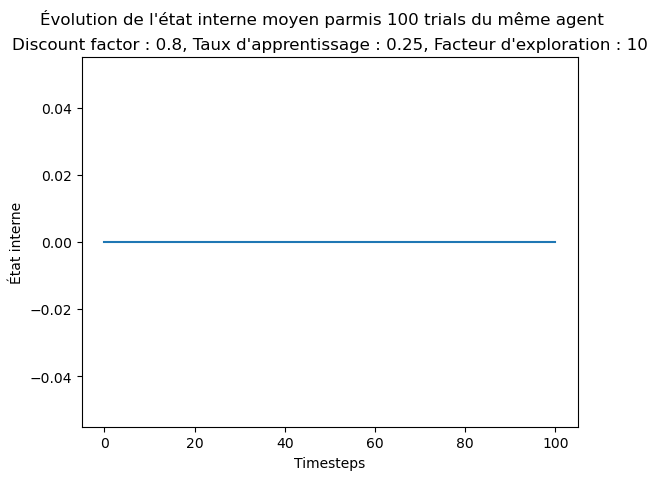

In [24]:
# avg of the 100 trials
state_history = np.mean(state_histories, axis=1)
plt.plot(state_history)
plt.suptitle("Évolution de l'état interne moyen parmis 100 trials du même agent")
plt.title(f"Discount factor : {gamma}, Taux d'apprentissage : {alpha}, Facteur d'exploration : {beta}")
plt.xlabel("Timesteps")
plt.ylabel("État interne")
plt.savefig("../figs/aversion_avg_state.png")
plt.show()

In [16]:
print(agent.q_table)

[[10.  0.]
 [ 0.  0.]]


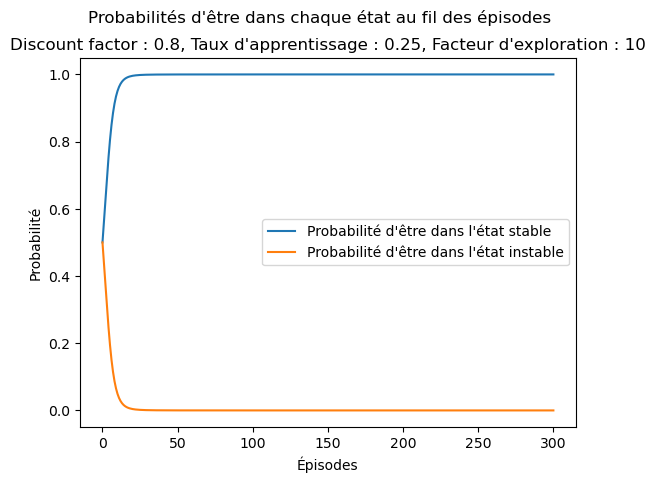

In [31]:


for step, q_values in enumerate(q_table_state):
    if step == 0:
        probs_state = [np.array([0.5, 0.5])] 
        continue # Skip la première itération car initialisation des probabilités des états
    max_q_values = np.max(q_values, axis=1, keepdims=True)
    stabilized_q_values = q_values - max_q_values
    exp_q_values = np.exp(stabilized_q_values)
    transition_probs = exp_q_values / np.sum(exp_q_values, axis=1, keepdims=True)
    
    current_probs = probs_state[-1] @ transition_probs
    probs_state.append(current_probs)

probs_state_0 = [prob[0] for prob in probs_state]
probs_state_1 = [prob[1] for prob in probs_state]


plt.plot(probs_state_0, label="Probabilité d'être dans l'état stable")
plt.plot(probs_state_1, label="Probabilité d'être dans l'état instable")
plt.suptitle("Probabilités d'être dans chaque état au fil des épisodes")
plt.title(f"Discount factor : {gamma}, Taux d'apprentissage : {alpha}, Facteur d'exploration : {beta}")
plt.xlabel("Épisodes")
plt.ylabel("Probabilité")
plt.legend()
plt.show()


100%|██████████| 300/300 [00:37<00:00,  8.07it/s]


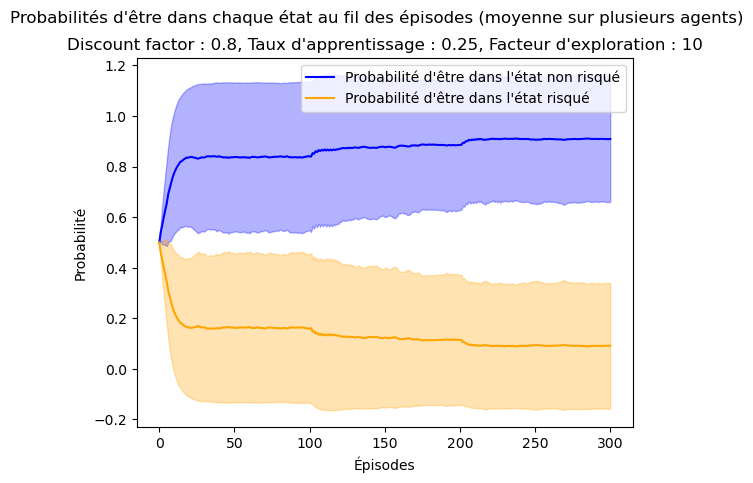

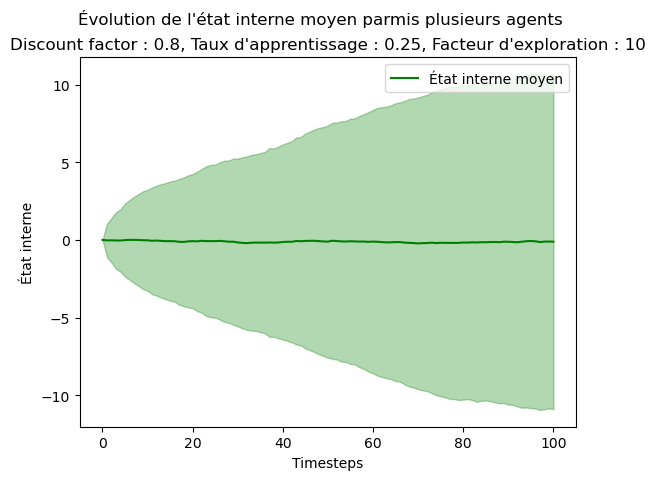

In [32]:
# override

nb_agents = 300
max_epoch = 3

# Initialize agents
agents = [
    QLearning(state_size=state_size, action_size=action_size, alpha=alpha, gamma=gamma, beta=beta)
    for _ in range(nb_agents)
]

# Initialize environment and tracking variables
state_histories_all = [[] for _ in range(max_timestep + 1)]
probs_state_all = []

# Train and evaluate each agent
for agent_idx in tqdm.tqdm(range(nb_agents)):
    agent = agents[agent_idx]
    q_table_state = [agent.q_table.copy()]
    
    for episode in range(max_epoch):
        internal_state, markov_state, current_timestep = env.reset()
        internal_state = int(internal_state)
        total_reward = 0
        done = False
        
        while not done:
            action = agent.choose_action(markov_state)
            internal_state, reward, done, next_markov_state, current_timestep = env.step(action)
            internal_state = int(internal_state)
            
            agent.update_q_value(markov_state, action, reward, next_markov_state)
            markov_state = next_markov_state
            total_reward += reward
            
            q_table_state.append(agent.q_table.copy())

    # Evaluate agent's policy
    state_histories = [[] for _ in range(max_timestep + 1)]
    for trials in range(10): 
        internal_state, markov_state, current_timestep = env.reset()
        done = False
        state_histories[current_timestep].append(int(internal_state))
        
        while not done:
            action = agent.choose_action(markov_state, evaluation=True)
            internal_state, reward, done, next_markov_state, current_timestep = env.step(action, show=False)
            markov_state = next_markov_state
            state_histories[current_timestep].append(int(internal_state))
    
    state_histories_all = [
        state_histories_all[t] + state_histories[t] for t in range(len(state_histories_all))
    ]

    # Compute transition probabilities
    probs_state = [np.array([0.5, 0.5])]
    for step, q_values in enumerate(q_table_state):
        if step == 0:
            continue
        max_q_values = np.max(q_values, axis=1, keepdims=True)
        stabilized_q_values = q_values - max_q_values
        exp_q_values = np.exp(stabilized_q_values)
        transition_probs = exp_q_values / np.sum(exp_q_values, axis=1, keepdims=True)
        current_probs = probs_state[-1] @ transition_probs
        probs_state.append(current_probs)
    
    probs_state_all.append(probs_state)

# Calculate mean and std for each timestep across all agents
state_history_means = np.array([np.mean(states) for states in state_histories_all])
state_history_stds = np.array([np.std(states) for states in state_histories_all])


probs_state_0_all = [[prob[0] for prob in probs] for probs in probs_state_all]
probs_state_1_all = [[prob[1] for prob in probs] for probs in probs_state_all]

probs_state_0_mean = np.mean(probs_state_0_all, axis=0)
probs_state_0_std = np.std(probs_state_0_all, axis=0)
probs_state_1_mean = np.mean(probs_state_1_all, axis=0)
probs_state_1_std = np.std(probs_state_1_all, axis=0)

# Plot probabilities with std deviation
plt.fill_between(range(len(probs_state_0_mean)), probs_state_0_mean - probs_state_0_std, probs_state_0_mean + probs_state_0_std, color="blue", alpha=0.3)
plt.fill_between(range(len(probs_state_1_mean)), probs_state_1_mean - probs_state_1_std, probs_state_1_mean + probs_state_1_std, color="orange", alpha=0.3)
plt.plot(probs_state_0_mean, label="Probabilité d'être dans l'état non risqué", color="blue")
plt.plot(probs_state_1_mean, label="Probabilité d'être dans l'état risqué", color="orange")
plt.suptitle("Probabilités d'être dans chaque état au fil des épisodes (moyenne sur plusieurs agents)")
plt.title(f"Discount factor : {gamma}, Taux d'apprentissage : {alpha}, Facteur d'exploration : {beta}")
plt.xlabel("Épisodes")
plt.ylabel("Probabilité")
plt.legend()
plt.show()

# Plot average state with std deviation
timesteps = range(len(state_history_means))
plt.fill_between(timesteps, state_history_means - state_history_stds, state_history_means + state_history_stds, color="green", alpha=0.3)
plt.plot(timesteps, state_history_means, label="État interne moyen", color="green")
plt.suptitle("Évolution de l'état interne moyen parmis plusieurs agents")
plt.title(f"Discount factor : {gamma}, Taux d'apprentissage : {alpha}, Facteur d'exploration : {beta}")
plt.xlabel("Timesteps")
plt.ylabel("État interne")
plt.legend()
plt.show()
